- Code tested with python 3.5.5 running on Azure Data Science Virtual Machine (Ubuntu 16.04)
- pip install -r requirements.txt to install required dependencies
- Put the 11 raw csv files (10 features files and 1 labels file) from the challenge in the same folder as this notebook, keeping their original filenames

In [1]:
#Import libraries
import pandas as pd
import numpy as np

from helper.utils import collinearity_check, train_val_split, normalize
%matplotlib inline

from helper.feat_sel import Feat_sel
from helper.model import Model, balanced_generator, Metrics

from keras.models import load_model
from helper.feedback import Feedback

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Business Use Case for Solution

- **Overview**: To generate prompt feedback on the driving behavior of Grab drivers at the end of each trip   
<br>
- **Objective**: 
    1. Build an interpretable predictive model for identification of dangerous driving based on telematics data
    2. Capture the driving behaviour responsible for each individual trip prediction to provide tailored feedback for safer driving   
<br>
- **Business outcome**: Promote safe driving culture among Grab drivers and reduce customer complaints regarding dangerous driving. Act as a deterrent against dangerous manoeuvres if the drivers know that their driving behaviors are being monitored.    
<br>
- **Value-add**: Currently, Grab provide drivers with weekly feedback of their driving patterns (speed, braking, acceleration etc). This solution could potentially add new features to this feedback report. In addition, prompt feedback (sms or app pop-up) after each trip is proposed. When the trip is still fresh in the driver's mind, such prompt feedback could be more effective than an accumulated report at the end of the week.   
<br>   
- **Implementation**:
    - *Inputs*: Telematics data collected from smart phones sensors during the trip
    - *Outputs*: Concrete textual feedback at the end of the trip on how to make the trip safer using local interpretable model-agnostic explainations (LIME)
    - *Model Choice*: Model interpretability was chosen over performance by employing a feature engineering-based approach (capture driving behaviors as features) compared to a black box RNN-type time series classification model  
    - *Feature Engineering Choices*: Careful choices were made during feature engineering to ensure that the model is not biased by features that do not make sense. Such choices were made in the interest of generalizability even if it resulted in some loss in model performance observed for this particular dataset   
<br>
- **Other Considerations**: 
    1. Model performance is currently not good enough to accurately identify dangerous driving. Hence, it could not be used as a way to decide on financial incentives/penalties or to validate customer complaints. However, it should still be sufficient as a means to provide feedback to drivers.
    2. Assuming that the labels are obtained from customer complaints, there could be concerns regarding label consistency. Different people would have a different idea of what constitutes dangerous driving. Although it is important to identify objective risk factors, it should be equally important for a customer-centric service provider to ensure that the customers *feel safe* during their ride. Customer feedbacks provide an excellent opportunity to identify the general consensus for a safe trip provided the dataset is large enough and unreasonable complaints could be filtered out.
    3. Given the noisy nature of telematics data, the 20000 trip dataset provided in this challenge may not be sufficient to build a resonably good model. The performance of this solution could possibly be improved with more data. Also, if more data is/become available, it may be a good idea to build country-specific or even city-specific models. This would tailor to the specific traffic/road conditions of the city and the local expectations for a safe ride.
    4. To achieve finer grouping of trips beyond just 'safe' and 'dangerous' and to circumvent the label consistency issue, unsupervised methods (similar to Mantouka E.G.  et al, Identification of driving safety profiles from smartphone data using machine learning techniques, 2019) could be used instead. Some simple calculations of statistical differences between aggregated feature values between anad within clusters could give an indication of model quality. However to properly validate the unsupervised model and figure out what each cluster acutally represents, substantial effort may be required to manually go through individual trips in the clusters in detail.

## Data Preprocessing (Multivariate time series data to Tabular data)

#### Re-orientate accelerometer axis

- Re-orientate accelerometer coordinate axis from the smartphone frame of reference to the vehicle frame of reference using the method outlined in Mohan P. et al, Nericell:Rich Monitoring of Road and Traffic Conditions using Mobile Smartphones, 2008. 
- Briefly, rotation of the axis was achieved by matrix multiplication with rotation matrices defined based on euler angles. To obtain the euler angles, acceleration was isolated to only one unknown component. 
- For example, when the vehicle is stationary or at a constant speed, the only acceleration experienced by the vehicle is gravity. The downward pointing acceleration in the vehicle frame of reference is the z-direction by my defintion. The angle between the acceleration_z (smartphone reference) and acceleration_z (vehicle reference) gives the euler angle theta_tilt as defined in the solution. 
- After reorientation, acceleration_x and acceleration_y oscillated about 0 and acceleration_z oscillated about g = 9.81 as expected (see figure below)

<img src="helper/reorientate.png">

#### Feature Engineering (Total of 39 features engineered)

- Refer to full feature list in feature_dictionary.xlsx found in the repository   
<br>   
- Data Cleaning before feature engineering
    - Rows with missing speed values removed
    - Rows with GPS accuracy > 20 removed 
    - Considered 'jumps' in time series when calculating rate of change of speed (acceleration), rate of change of acceleration (vehicular jerk) and bearing changes
    - Transformed bearing change to between 0 and 180 degrees   
<br>   
- **Features engineering**:    
<br>   
- Statistics (max, peak-to-average difference(in terms of s.d.), risky behaviour count) computed for each set of features
    - Maximum: represents high values observed in the driving behavior feature
    - Peak-to-average difference: represents presence of anomalously high outliers observed in the driving behavior feature
    - Risky behavior count: Instances of the driving behavior feature above a set threshold   
<br>   

- Feature Types
    1. Non-event based features: Directly calculate statistics from all available time points  
        a. **Speed**   
        b. **Vehicular jerk**   
<br>
    2. Event-based features: Event identification based on specific conditions to isolate time period invovled in event. For accelerometer data, peak identification was used for event detection    
        c. **Forward acceleration**: peak identification from reorientated acceleration_x  
        d. **Braking**: peak identification from negative reorientated acceleration_x   
        e. **Left-right turn speed**: Speed when 30 degrees < Bearing Change <= 150 degrees  
        f. **Left-right turn aggression**: Speed * sqrt(Bearing Change) when 30 degrees <= Bearing Change <= 150 degrees     
        g. **U-turn speed**: Speed when Bearing Change > 150 degrees    
        h. **Turn lateral acceleration**: peak identification from reorientated acceleration_y when Bearing Change > 30 degrees   
        f. **Lane Change lateral acceleration**: peak identification from reorientated acceleration_y when Bearing Change <= 30 degrees   
<br>   
    3. Peak Identification
        - Peaks in accelerometer time series indicated the prescence of an event
        - Identify peaks from reorientated acceleration data that are above a threshold   
        - Seperate statistics computed for peak values and a characteristic value where the peak values were normalized by the peak width (peak value/peak width)
        - See figure below for an example of peak identification in forward acceleration   
<br>   
    4. No event detected during trip
        - If a particular type of event is not detected during the trip, a placeholder nan value is given for the max and peak-to-average statistics of that event
        - After the features for all trips were generated, nan values were filled with the median of the feature column disregarding the nan values
        - Assigning a median score instead of 0 to a feature for an undetected event makes more sense. As features were designed to be positively correlated with dangerous driving, a 0 value for undetected features will bias the trip towards safe driving
        - From model testing during the development of this solution, it is surprising to note that assigning a 0 value to undetected features instead of the median value would result in an improvement in model performance (AUC_ROC ~ +1%,  Average precision ~ +1%)   
<br>         
- Sanity Check:
    - At least 60s of trip data must remain after data cleaning
    - Reorientated acceleration_z must oscillate close to g = 9.81
    - For the data set used to develop this solution, the trips that did not satisfy the sanity checks were dropped.
    - For the hold-out set used to evaluate the performance of this solution (in test.py), the trips that did not satisfy the sanity checks would be filled with placeholder nan values for all columns. After the features for all trips were generated, these nan values would be filled with the median of the feature column disregarding the nan values      
<br>   
    
- Features not included:
    - From model testing during the development of this solution, inclusion of features such as mean speed and lane change frequency could improve model performance (AUC_ROC ~ +1%,  Average precision ~ +1%)
    - From LIME explainations, low/high mean speed and low lane change frequency were found to be important for predicting dangerous driving while moderate mean speed and high lane change frequency corresponds to safe driving
    - These features were believed to be related to external conditions on the road. For example low mean speed may represent a congested road, where impatient drivers have a tendency to drive dangerously. Low lane change frequency can represent a long straight road with little traffic during the trip, causing the driver to be complacent and drive with less caution.
    - Although these features would have helped to improve model performance, they are not useful as feedback information to the driver as these features clearly exhibit a much less causal relationship with dangerous driving. For example, if the driver makes a turn at high speed, it is a clear instance of dangerous driving. Although low mean speed can be linked to dangerous driving in general, it is less clear-cut at the single-trip level with many exogenous factors invovled.
    - Exclusion of these features can help to prevent model bias towards these less causal features and ensures that the feedback obtained are centered around the other more clear-cut features. 

<img src="helper/forw.png">

In [ ]:
#!python preprocess_train.py

# Running preprocess_train.py takes ~ 9 hrs
# Alternatively, download preprocess.csv from  https://drive.google.com/drive/folders/1PADzFR8T5pVn0S9kmqB6598e9SHS2EZl?usp=sharing and put it in the same folder as this notebook

## Data Preparation for Model

- **Collinearity Check**: To make sure that most features are not highly correlated. Do not want to include excessive features that represents the same information. Highly correlated features can also affect the quality of feature selection performed below
- **Train-val split**: 80:20 train-val split
- **Normalization**: Normalized train data to between 0 and 1. Normalized validation data based on min and range of train data.
- **Feature Selection**:
    - To isolate a smaller set of relevant feature and remove noisy features 
    - Although the multilayer perceptron neural network used in the solution should be able to perform automatic feature selection, 20,000 data points may be too small to achieve effective feature selection in this way. Hence, feature selection was performed using traditional machine learning methods that is known to work with smaller datasets.
    - **Boruta**: Select relevant features that have higher variable importance in a random forest model than randomized 'shadow' variables
    - **Lasso**: Obtain a distribution of lasso coefficients for each feature by building a large number of lasso models on bootstrapped samples. Select relevant features with lasso coefficients that are significantly (95% confidence) different from 0 .
    - Final feature set from a conservative approach to union the 2 feature sets obtained from boruta and lasso

In [2]:
#Read data
preprocess = pd.read_csv('preprocess.csv')
preprocess.shape

(19610, 40)

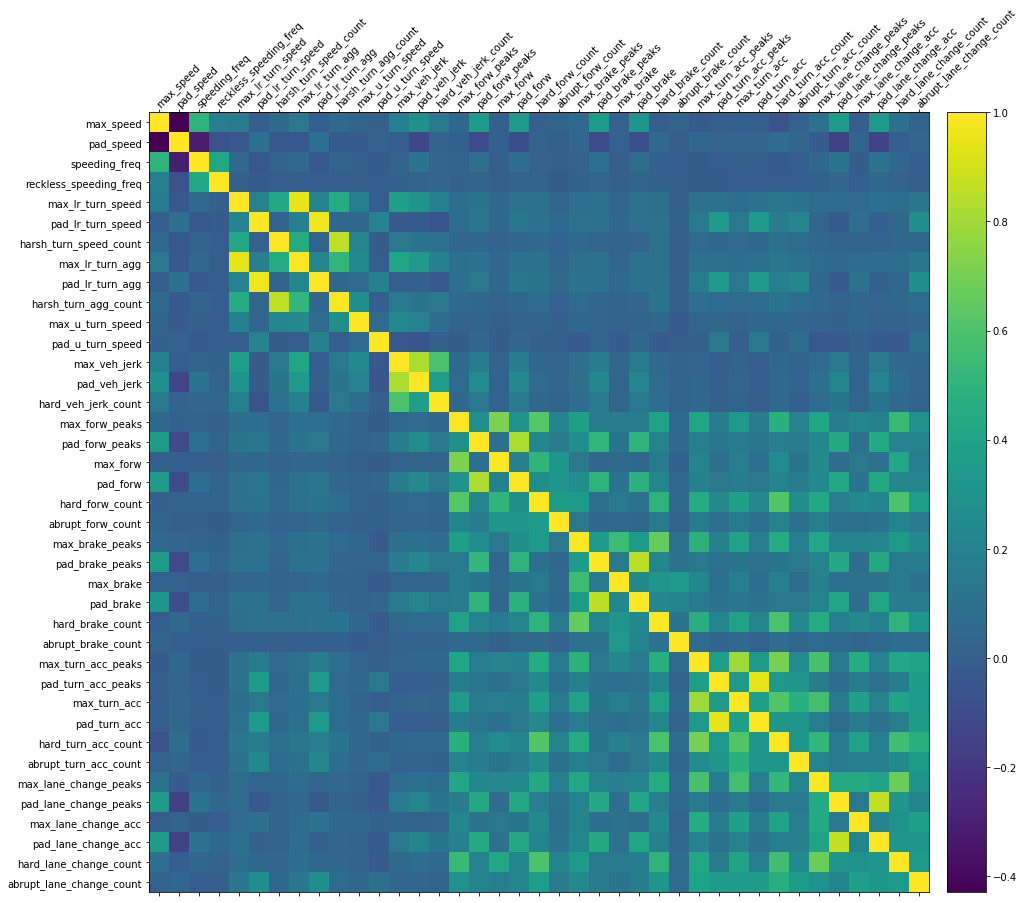

In [3]:
# Collinearity check
collinearity_check(preprocess)

In [4]:
#Train-val split (80:20) 
labels = pd.read_csv('part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')
X_train, X_val, y_train, y_val = train_val_split(preprocess, labels)

#Data Normalization
X_train, X_val = normalize(X_train, X_val)

In [5]:
#Feature Selection using Boruta and Lasso to isolate relevant feature set
feat_sel = Feat_sel(preprocess, X_train, y_train) 
feature_sel1 = feat_sel.boruta()
feature_sel2 = feat_sel.lasso()

X_train, X_val, features = feat_sel.make_feat_set(feature_sel1, feature_sel2, X_val)

## Model
- Data cleaning
    - Remove trips with duplicated labels. These labels were found to be conflicting.    
<br>   
- **Multi-layer perceptron neural network** chosen as the predictive model
    - 6 fully-connected layers optimized using ADAM based on categorical cross-entropy loss
    - Regularized using batch normalization, dropouts and L2 weights decay   
<br>
- **Custom generator function to generate balanced mini-batches**
    - As the train dataset is imbalanced (~1:3), a custom generator was used for resampling to ensure a balanced mini-batch
    - As the features were designed to be positively correlated to dangerous driving, a rough set of samples that clearly corresponds to safe/dangerous driving can be obtained by summing up all the normalized feature values and setting a cutoff threshold (refer to code for details). 
    - Only samples with the correct true labels are selected in this way. For example, even though the sum of feature values in sample A is above the threshold for clear dangerous driving; if the true label is safe driving, sample A is not selected to be a sample with clear dangerous driving. 
    - During resampling the weight of resampling these samples with clear safe/dangerous driving were slightly increased
    - This may encourage (but not force) the model to learn that high feature values should correspond to dangerous driving
    - One of the main reason for choosing a multilayer perceptron neural network over traditional machine learning models e.g. XgBoost is to take advantage of a resampling generator like this   
<br>
- **Learning rate schedule**
    - Stochastic gradient descent with restarts (cosine annealing) used as learning rate schedule
    - Restarts helps to get out of local minima and saddle points in loss function   
<br>
- Model evaluation
    - Recall, precision, F1 score at classification threshold = 0.5; as well as non-threshold based metrics, auc-roc and average precision were reported
    - As the purpose of this model is not for decision-making at a particular classification threshold, non-threshold based metrics may be more useful to gauge the overall quality of the model.
    - The recall score was observed to be significantly higher than the precision score. This makes sense as it would be more likely for *slightly dangerous* trips to be unreported (correct prediction by model but captured as false positives due to mis-labeling) than for *slightly safe* trips to be misreported (correct predicton by model but captured as false negative due to mis-labeling). People are not likely to report a driver for dangerous driving unless they are really very unhappy about the driving.   
<br>   
- Possible improvements
    - As non-threshold based metrics such as roc-auc would be more useful, it may be better to optimize directly on a loss function based on roc-auc rather than cross-entropy loss. However, functions such as roc-auc are non-differentiable and by definition needs to be calculated over the whole dataset instead of batch-wise. Hence, more time may be required to find a way to implement this type of loss function

In [6]:
model = Model(X_train, X_val, y_train, y_val)

#Compile model
model.compile_model()

#Prepare for model
clear_pos, clear_neg = model.get_clear_pos_neg_samples()
metrics = Metrics()
lrsch = model.sgd_with_restarts()

#Fit Model
model.fit_model(clear_pos, clear_neg, lrsch, metrics)

Epoch 20: Val. ROC-AUC Score = 0.625, Val. Average Precision Score = 0.373
Epoch 40: Val. ROC-AUC Score = 0.636, Val. Average Precision Score = 0.391
Epoch 60: Val. ROC-AUC Score = 0.646, Val. Average Precision Score = 0.405
Epoch 80: Val. ROC-AUC Score = 0.649, Val. Average Precision Score = 0.414
Epoch 100: Val. ROC-AUC Score = 0.652, Val. Average Precision Score = 0.418
Epoch 120: Val. ROC-AUC Score = 0.654, Val. Average Precision Score = 0.42
Epoch 140: Val. ROC-AUC Score = 0.654, Val. Average Precision Score = 0.421
Epoch 160: Val. ROC-AUC Score = 0.652, Val. Average Precision Score = 0.42
Epoch 180: Val. ROC-AUC Score = 0.654, Val. Average Precision Score = 0.421
Epoch 200: Val. ROC-AUC Score = 0.654, Val. Average Precision Score = 0.421
Epoch 220: Val. ROC-AUC Score = 0.657, Val. Average Precision Score = 0.423
Epoch 240: Val. ROC-AUC Score = 0.656, Val. Average Precision Score = 0.423
Epoch 260: Val. ROC-AUC Score = 0.656, Val. Average Precision Score = 0.424
Epoch 280: Val. RO

In [7]:
#Evaluate model
model.eval_model()

--------------------------------------
Train:
   Precision: 0.3598508390304537
   Recall: 0.6105984708673873
   F1 Score: 0.45283018867924524

   ROC-AUC Score: 0.6856937420607339
   Average Precision Score: 0.4394004475933777
--------------------------------------
Test:
   Precision: 0.3495085995085995
   Recall: 0.5759109311740891
   F1 Score: 0.4350152905198777

   ROC-AUC Score: 0.6572503615546228
   Average Precision Score: 0.4254477163123256
--------------------------------------


## Trip Feedback for Drivers

- **Local interpretable model-agnostic explaination (LIME)** used to isolate features and capture driving behavior that are important for **each individual trip prediction**
- Fits a linear classifier that is a good approximation to the neural network model locally around the trip of interest
- Of particular interest are the features that contributes to dangerous driving ie positive coefficients
- As LIME outputs are based on a local linear classifier, it is valid to conclude that adjusting the values of these features of interest (e.g. reducing max speed when performing a left-right turn) could shift the prediction from dangerous driving to safe driving. This is not true for other model interpretability methods like shapley values which gives a single numerical value for each feature instead of a model. Such conclusions are equivalent to feedback on how to make the trip safer
- Feedback included for trips with both predicted safe and dangerous driving, even safe drivers should have room for improvements
- Simple example of textual feedback that can be passed to drivers shown below (based on top 5 features)
- LIME visualization shown below as image instead of code output as the code output does not display correctly in GitHub

In [8]:
# Model training takes about ~ 15 mins
# Alternatively, download model.h5 from  https://drive.google.com/drive/folders/1PADzFR8T5pVn0S9kmqB6598e9SHS2EZl?usp=sharing and put it in the same folder as this notebook
trained_model = load_model('model.h5')
feedback = Feedback(trained_model, X_train, X_val, y_val, features)

#Get feedback for a single trip in validation set
trip_idx = 86
feedback.feedback_text(trip_idx)

Predicted Probability: 0.23100000619888306
Label: Safe

Trip Feedback:
   Slow down when turning.
   Slow down.


In [ ]:
#feedback.show_in_notebook()

<img src="helper/lime_viz.png">